# Collection and Storage

In [103]:
import requests,json,os
import re,datetime
import shutil
import matplotlib.pyplot as mp
import pandas as pd
import numpy as np
import http.client
from time import sleep
import seaborn as sns

In [104]:
soccer_data_search_key = os.getenv('auth_key')
print(soccer_data_search_key)

13df3e32632f4ebd90020eb9109ee05d


In [105]:
dir_path='../data/raw_data'       #Creating directory.
os.makedirs(dir_path,exist_ok=True)

In [106]:
for season in range(2015,2017):
    connection = http.client.HTTPConnection('api.football-data.org') #Downloading data for a season from API using API key.            
    headers = { 'X-Auth-Token': soccer_data_search_key, 'X-Response-Control': 'full' } 
    connection.request('GET', '/v1/competitions?season='+str(season), None, headers )
    soc_data = json.loads(connection.getresponse().read().decode())
    
    season_path = os.path.join(dir_path, str(season)) #Creating folders for different seasons.  
    os.makedirs(season_path,exist_ok=True)
    
#     print('\n')
#     print(season, len(soc_data))
    for i in range(0,len(soc_data)): #Iterating through the season data and extracting competition names.
        comp = re.sub(r'\d{4}/\d{2}', '', soc_data[i]['caption'])
        comp = re.sub(r'\d{4}', '', comp)
#         print(comp)
    
        com_path = os.path.join(season_path, comp)   #Creating folders for different competitions.
        os.makedirs(com_path,exist_ok=True)
        
        with open(comp,'w')as outfile: #Creating JSON files for each competition.
            json.dump(soc_data[i],outfile)
                       
        team_path = os.path.join(dir_path, 'Teams')   # Creating folders for teams.
        os.makedirs(team_path,exist_ok=True)
        
        connection = http.client.HTTPConnection('api.football-data.org') #Downloading data for a competition from API using API key.
        headers = { 'X-Auth-Token': soccer_data_search_key, 'X-Response-Control': 'minified' }
        connection.request('GET', '/v1/competitions/'+str(soc_data[i]['id'])+'/fixtures', None, headers )
        fix_data = json.loads(connection.getresponse().read().decode())
        
        fix_path = os.path.join(com_path, 'Fixtures')   #Creating folders for fixture of different competitions.
        os.makedirs(fix_path,exist_ok=True)
        
        for j in range(0,len(fix_data['fixtures'])): #Creating JSON files for each fixture.
            fix=fix_data['fixtures'][j]['homeTeamName']+' .Vs. '+fix_data['fixtures'][j]['awayTeamName'] 
            try:
                with open(fix,'w')as outfile:
                    json.dump(fix_data['fixtures'][j],outfile)
            except FileNotFoundError:
                        pass
        
        for files in os.listdir('./'): #Iterating through each created JSON file and moving it to the appropriate location.
            if not files.endswith('.ipynb'):
                if not files.endswith('.ipynb_checkpoints' ):
                    if ' .Vs. ' in files:
                        try:
                            shutil.move(os.path.join('./',files),os.path.join(fix_path,files+'.json'))
                        except OSError:
                            pass
                    else:
                        try:
                            shutil.move(os.path.join('./',files),os.path.join(com_path,files+'.json'))
                        except OSError:
                            pass

In [113]:
for root, dirs, files in os.walk(dir_path):
    if not root.endswith('/Fixtures'):
        if not root.endswith('/Teams'): # Iterting through competiton JSON files.
            for f in files:
                if f.endswith('.json'):
                    if not 'Table' in f:
                        if not '.DS_Store' in f:
                            with open(os.path.join(root,f), 'r', encoding='utf-8', errors="ignore") as json_file:
                                socdata=json.load(json_file) #Reading each JSON file

                                comp = re.sub(r'\d{4}/\d{2}', '', socdata['caption'])
                                comp = re.sub(r'\d{4}', '', comp)

                                connection = http.client.HTTPConnection('api.football-data.org') #Downloading table data of each competition using the comp ID.                       
                                headers = { 'X-Auth-Token': soccer_data_search_key, 'X-Response-Control': 'minified' }
                                connection.request('GET', '/v1/competitions/'+str(socdata['id'])+'/leagueTable', None, headers )
                                table_data = json.loads(connection.getresponse().read().decode())
                                
                                sleep(2.2) #Delaying the loop by 2.2 second to limit the call rate.
                                
                                with open(comp +'Table','w')as outfile:
                                    json.dump(table_data,outfile)    #Creating JSON files for each competition table.
                                
                                    for files in os.listdir('./'):
                                        if not files.endswith('.ipynb'):  #Iterating through each created JSON file and moving it to the appropriate location.    
                                            if not files.endswith('.ipynb_checkpoints' ):
                                                if comp in files:
                                                    try:
                                                        shutil.move(os.path.join('./',files),os.path.join(root,files+'.json'))
                                                    except OSError:
                                                        pass


In [108]:
for root, dirs, files in os.walk(dir_path):
    if not root.endswith('/Fixtures'):
        if not root.endswith('/Teams'):  # Iterting through competiton JSON files.
            for f in files:
                if f.endswith('.json'):
                    if not 'Table' in f:
                        if not '.DS_Store' in f:
                            with open(os.path.join(root,f), 'r', encoding='utf-8', errors="ignore") as json_file:
                                socdata1=json.load(json_file) #Reading each JSON file which is not table data.
                            
                                connection = http.client.HTTPConnection('api.football-data.org')  #Downloading team data of each competition using the comp ID.
                                headers = { 'X-Auth-Token': soccer_data_search_key, 'X-Response-Control': 'minified' }
                                connection.request('GET', '/v1/competitions/'+str(socdata1['id'])+'/teams', None, headers )
                                team_data = json.loads(connection.getresponse().read().decode())
        
                                for t in range(0,len(team_data['teams'])):
                                    try:
                                        with open('Team: '+team_data['teams'][t]['name'],'w')as outfile:
                                            json.dump(team_data['teams'][t],outfile)  #Creating JSON files for each team.

                                    except FileNotFoundError:
                                        pass
                                    
                                    for files in os.listdir('./'):
                                        if not files.endswith('.ipynb'):  #Iterating through each created JSON file and moving it to the appropriate location.      
                                            if not files.endswith('.ipynb_checkpoints' ):
                                                if 'Team: ' in files:
                                                    try:
                                                        shutil.move(os.path.join('./',files),os.path.join(dir_path+'/Teams',files+'.json'))
                                                    except OSError:
                                                        pass
   

# Analysis 1
Analyzed each of the leagues point table data to find which league is more competative.

In [114]:
leagueTable=pd.DataFrame()
for root, dirs, files in os.walk(dir_path):
    if not root.endswith('/Fixtures'):
        if not root.endswith('/Teams'):  # Iterting through competiton JSON files.
            if '/2015' in root:
                for f in files:
                    if f.endswith('.json'):
                        if 'Table' in f:   # Selecting the table files for each  league.
                            if not '.DS_Store' in f:
                                with open(os.path.join(root,f), 'r', encoding='utf-8', errors="ignore") as json_file:
                                    teamStand=json.load(json_file)
                                    try:
                                        table=pd.DataFrame.from_dict(teamStand['standing'], orient='columns', dtype=None)
                                        table['League Name']=f[:-11] # Adding league names to each of the leagues data.
                                    except KeyError:
                                        pass
                                    leagueTable=pd.concat([leagueTable,table])

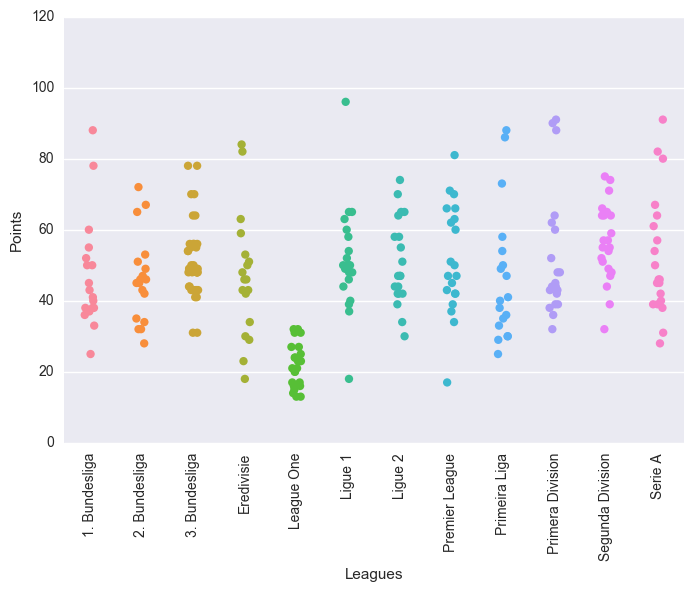

In [115]:
#Plot for point clusters for each league.
ax = sns.stripplot(x="League Name", y="points", data=leagueTable, jitter=1,size=6)      
#ax = sns.boxplot(x="League Name", y="points", data=leagueTable)   
mp.xticks(rotation=90)
mp.ylabel('Points')
mp.xlabel('Leagues')
mp.show()